## Import Modules and Libraries

This code cell imports the necessary Python libraries for data manipulation, numerical operations, and plotting.


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

## Load Data
This code cell loads three CSV files into pandas DataFrames:

* sales.csv is loaded into sales_df.
* promo_price.csv is loaded into promo_price_df.
* regular_price.csv is loaded into regular_price_df.

These DataFrames contain information about sales, promotional prices, and regular prices, respectively.

In [ ]:
sales_df = pd.read_csv('sales.csv')
promo_price_df = pd.read_csv('promo_price.csv')
regular_price_df = pd.read_csv('regular_price.csv')

## Merge Data

Merge the dataframes and create the promo flag where the promo price is lower than the regular price and of course a promo price exists.

There is no instances where promo price is higher than the regular one, but the check should be performed.

In [ ]:
# Merge the dataframes on the common keys
merged_df = pd.merge(
    sales_df,
    regular_price_df,
    on=['daydt', 'item_id', 'store_id'],
    how='left'
)

merged_df = pd.merge(
    merged_df,
    promo_price_df,
    on=['daydt', 'item_id', 'store_id'],
    how='left'
)

# Create promotion flag
merged_df['promo_flag'] = np.where(
    (merged_df['promo_price'] < merged_df['regular_price']) &
    (~merged_df['promo_price'].isna()),
    1, 0
)

In [ ]:
# Check merge success rate
print(f"Sales records with regular prices: {(~merged_df['regular_price'].isna()).mean():.2%}")
print(f"Sales records with promo prices: {(~merged_df['promo_price'].isna()).mean():.2%}")

Sales records with regular prices: 100.00%
Sales records with promo prices: 2.09%


### Find date ranges

Explore the data for each combination of item/store and check the availability
calendar wise.

In [ ]:
# Check if all items are available at all times
coverage = merged_df.groupby('item_id')['daydt'].agg(['min', 'max', 'nunique'])
print(coverage)

                min         max  nunique
item_id                                 
item1    2019-01-02  2022-09-11     1349
item2    2019-01-02  2022-09-11     1338
item4    2019-01-02  2022-09-11     1349
item5    2019-09-15  2022-09-11     1093
item6    2019-01-08  2022-09-11     1343
item7    2020-01-15  2022-09-11      971


In [ ]:
# Have a look at the data
merged_df

,daydt,item_id,store_id,sales,regular_price,promo_price,promo_flag
0,2022-05-01,item7,store2,0,35.2,NaN,0
1,2021-09-25,item7,store2,0,35.2,NaN,0
2,2021-09-26,item7,store2,0,35.2,NaN,0
3,2021-09-27,item7,store2,0,35.2,NaN,0
4,2021-09-28,item7,store2,0,35.2,NaN,0
...,...,...,...,...,...,...,...
12113,2019-01-05,item4,store2,5,24.0,NaN,0
12114,2019-01-06,item4,store2,5,24.0,NaN,0
12115,2019-01-07,item4,store2,5,24.0,NaN,0
12116,2019-01-08,item4,store2,6,24.0,NaN,0


## Explore Basic Statistics

---

### 📅 **Basic Dataset Information**

* **Time Period**: The dataset spans **over 3.5 years**, from **January 2019 to September 2022**, which is a solid time window for time series analysis and demand forecasting. This duration likely includes **seasonal effects, promotional cycles, and possible disruptions (e.g., COVID-19)**.
* **Item & Store Coverage**: With **6 unique items** and **4 stores**, the dataset is relatively compact. This limited dimensionality makes it suitable for exploring **hierarchical** or **cross-sectional forecasting** (e.g., item-level, store-level, or item-store combinations).
* **Observation Count**: **12,118 total observations** suggest that not every item-store-date combination is present, implying **sparse or irregular data** for some entities. This should be validated during preprocessing and could influence model granularity.

---

### 📊 **Summary Statistics for Numerical Columns**

#### `sales_value`

* High **standard deviation** (1071.97) and **maximum value (20,434)** relative to the **mean (520.02)** indicate **high variance and potential outliers**. This skewness may impact model performance, and **log transformation or outlier handling** might be beneficial.
* A **median of 19.40** suggests most transactions are of low value, but a few very large values drive the mean up—another indicator of skewness.

#### `regular_price`

* The price distribution is more **stable**, with a **mean of 175.37**, **max of 330.40**, and **low standard deviation** relative to `sales_value`. It could serve as a good **predictor variable**.
* The presence of **distinct quartiles** suggests item price variability (e.g., cheap vs. premium items), which should be accounted for in modeling.

#### `promo_price`

* This column has **significantly fewer observations (only 253 rows)**, pointing to **extensive missingness (≈98%)**. This is supported by the missing value summary.
* The `promo_price` values are generally **lower than regular prices**, which aligns with expectations. The effectiveness of promotions could be modeled, but the missingness should be carefully handled (e.g., imputation, flagging).

---

### ❓ **Missing Values Analysis**

* **`promo_price` is missing in 11,865 out of 12,118 rows (\~98%)**, suggesting that:

  * Most transactions may not involve promotions.
  * This field is **sparse by design**, only populated when a promotion occurs.

* **`promo_flag` has of course 0 missing values**, and this reliably indicates promotion presence, so it can be used as a binary feature in modeling.

---

### 🔮 **Implications for Demand Forecasting (Probabilistic Sales Prediction)**

* **Forecasting Objective**:
  The goal is to generate **probabilistic forecasts of sales**, meaning the model should predict a **distribution** (e.g., quantiles or full probability distributions) instead of point estimates. This approach is particularly valuable for **decision-making under uncertainty**, such as inventory planning or risk-aware supply chain operations.

* **Suitability of Data**:

  * The dataset spans a **sufficient historical period** to model temporal patterns such as **seasonality**, **holidays**, and **promotion effects**.
  * The moderate number of **item-store combinations** (6 × 4) allows for **hierarchical or grouped probabilistic modeling**, such as **DeepAR**, **NGBoost**, **Quantile Regression**, or **Bayesian models**.

* **Sales Distribution Characteristics**:

  * The `sales_value` and presumably the underlying `sales` variable show **high variance, zero-inflation, and skewness**, making probabilistic modeling a better fit than traditional point forecasting.
  * The **long-tailed sales value distribution** implies that models should capture **extreme values and uncertainty**, not just central tendencies.

* **Promo Impact**:

  * Sparse promotional data (only 253 entries for `promo_price`) may limit direct usage, but the `promo_flag` can still serve as a **predictive feature or conditioning variable** for estimating **sales uplift** during promotions.
  * Probabilistic models can better capture **increased sales variance** under promotions compared to point estimates.

* **Modeling Considerations**:

  * Ensure **temporal features** (day of week, month, holidays) are extracted to capture **seasonal effects**.
  * Consider **item-store-level models** to reflect heterogeneity.
  * Use evaluation metrics suited for probabilistic forecasting such as **Pinball Loss**, **CRPS (Continuous Ranked Probability Score)**, or **Prediction Interval Coverage**.

---




In [ ]:
# Convert 'daydt' to datetime objects
merged_df['daydt'] = pd.to_datetime(merged_df['daydt'])

# Calculate sales value
merged_df['sales_value'] = np.where(
    merged_df['promo_flag'] == 1,
    merged_df['sales'] * merged_df['promo_price'],
    merged_df['sales'] * merged_df['regular_price']
)

# Summary Statistics
print("="*50)
print("Basic Dataset Information")
print("="*50)
print(f"Time period: {merged_df['daydt'].min().date()} to {merged_df['daydt'].max().date()}")
print(f"Number of unique items: {merged_df['item_id'].nunique()}")
print(f"Number of unique stores: {merged_df['store_id'].nunique()}")
print(f"Total observations: {len(merged_df)}")

print("\n" + "="*50)
print("Summary Statistics for Numerical Columns")
print("="*50)
print(merged_df[['sales_value', 'regular_price', 'promo_price']].describe().round(2))

print("\n" + "="*50)
print("Missing Values Analysis")
print("="*50)
print(merged_df.isnull().sum())

Basic Dataset Information
Time period: 2019-01-02 to 2022-09-11
Number of unique items: 6
Number of unique stores: 4
Total observations: 12118

Summary Statistics for Numerical Columns
       sales_value  regular_price  promo_price
count     12118.00       12118.00       253.00
mean        520.02         175.37       186.53
std        1071.97         130.07       114.57
min           0.00          18.50        15.50
25%           0.00          25.60        20.50
50%          19.40         259.70       252.60
75%         408.00         300.50       264.30
max       20434.00         330.40       296.00

Missing Values Analysis
daydt                0
item_id              0
store_id             0
sales                0
regular_price        0
promo_price      11865
promo_flag           0
sales_value          0
dtype: int64


In [ ]:
# Create item-store combinations list
item_store_combos = merged_df.groupby(['item_id', 'store_id']).size().reset_index()[['item_id', 'store_id']]
item_store_combos['combo'] = item_store_combos.apply(lambda x: f"Item {x['item_id']} - Store {x['store_id']}", axis=1)
combo_list = item_store_combos['combo'].tolist()
combo_list

['Item item1 - Store store1',
 'Item item1 - Store store2',
 'Item item1 - Store store4',
 'Item item2 - Store store2',
 'Item item4 - Store store2',
 'Item item5 - Store store3',
 'Item item6 - Store store3',
 'Item item6 - Store store4',
 'Item item7 - Store store2',
 'Item item7 - Store store4']

## Check for Missing Dates in Item-Store Time Series

This block analyzes the temporal completeness of each item-store time series by comparing available dates to the full dataset date range. It identifies missing dates, calculates coverage percentage, and summarizes gaps across all series. This step is essential to detect data sparsity or irregularities before building forecasting models, especially when using time series or sequence-based methods.

In [ ]:
# Create a date range covering the entire dataset period
# This will be used as a reference to identify missing dates for each item-store combination
full_date_range = pd.date_range(start=merged_df['daydt'].min(), end=merged_df['daydt'].max())

# Define a function to evaluate date completeness for a given group (i.e., item-store pair)
# It compares the actual dates in the group with the full date range
# Returns summary statistics including the number and percentage of missing days
def check_missing_dates(group):
    group_dates = group['daydt']
    missing_dates = full_date_range.difference(group_dates)
    return pd.Series({
        'start_date': group_dates.min(),      # First date available in the group
        'end_date': group_dates.max(),        # Last date available in the group
        'total_days': len(group_dates),       # Total number of observed dates
        'missing_days': len(missing_dates),   # Number of missing dates
        'missing_dates_list': missing_dates if len(missing_dates) <= 10 else f"{len(missing_dates)} missing dates (first 10 shown)",  # Show a sample
        'date_coverage': f"{round(len(group_dates)/len(full_date_range)*100, 2)}%"                                                    # Coverage as percentage of the full period
    })

# Apply the missing date analysis to each (item_id, store_id) pair
# This helps identify which time series are complete or have gaps
date_completeness = merged_df.groupby(['item_id', 'store_id']).apply(check_missing_dates).reset_index()

# Display date completeness stats for a few combinations
# Useful for quickly checking patterns and potential data issues
print("\nDate Completeness by Item-Store:")
print(date_completeness.head())

# Show summary statistics across all item-store series
# Helps understand overall data sparsity and completeness
print(f"\nSummary statistics:")
print(date_completeness[['total_days', 'missing_days']].describe())

# Identify item-store pairs with missing dates
# These may require special handling (e.g., imputation, exclusion) before forecasting
incomplete_series = date_completeness[date_completeness['missing_days'] > 0]
print(f"\nNumber of item-store combinations with missing dates: {len(incomplete_series)}")

# Show a few examples of incomplete series
print("\nSample of incomplete series:")
print(incomplete_series.head())


Date Completeness by Item-Store:
  item_id store_id start_date   end_date  total_days  missing_days  \
0   item1   store1 2019-01-02 2022-09-11        1342             7   
1   item1   store2 2019-01-02 2022-09-11        1348             1   
2   item1   store4 2019-01-02 2022-09-11        1346             3   
3   item2   store2 2019-01-02 2022-09-11        1338            11   
4   item4   store2 2019-01-02 2022-09-11        1349             0   

                                  missing_dates_list date_coverage  
0  DatetimeIndex(['2021-04-25', '2021-05-05', '20...        99.48%  
1  DatetimeIndex(['2020-07-21'], dtype='datetime6...        99.93%  
2  DatetimeIndex(['2021-03-09', '2022-04-27', '20...        99.78%  
3                  11 missing dates (first 10 shown)        99.18%  
4  DatetimeIndex([], dtype='datetime64[ns]', freq...        100.0%  

Summary statistics:
        total_days  missing_days
count    10.000000     10.000000
mean   1211.800000    137.200000
std     237

/tmp/ipython-input-9-3587249587.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_completeness = merged_df.groupby(['item_id', 'store_id']).apply(check_missing_dates).reset_index()


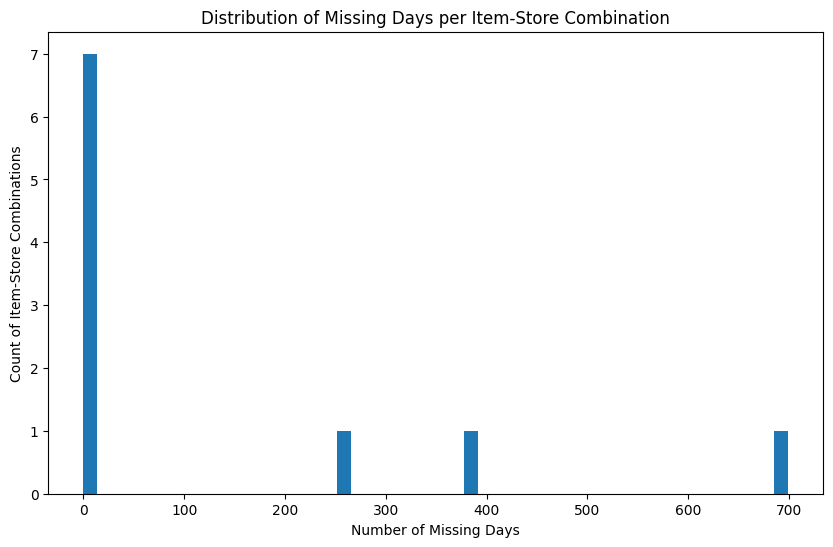

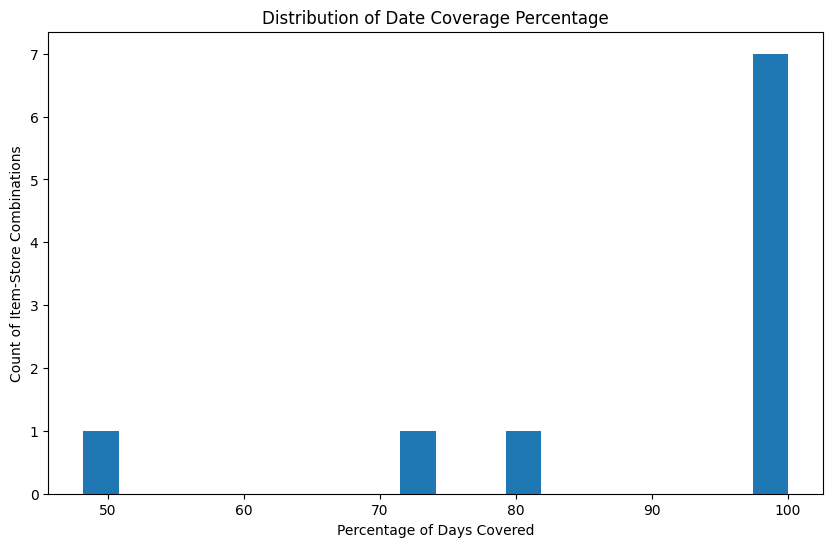

In [ ]:
# Plot distribution of missing days
plt.figure(figsize=(10, 6))
plt.hist(date_completeness['missing_days'], bins=50)
plt.title('Distribution of Missing Days per Item-Store Combination')
plt.xlabel('Number of Missing Days')
plt.ylabel('Count of Item-Store Combinations')
plt.show()

# Plot coverage percentage
plt.figure(figsize=(10, 6))
plt.hist(date_completeness['date_coverage'].str.replace('%','').astype(float), bins=20)
plt.title('Distribution of Date Coverage Percentage')
plt.xlabel('Percentage of Days Covered')
plt.ylabel('Count of Item-Store Combinations')
plt.show()

In [ ]:
# Save the new dataframe to be used for modeling later.
merged_df.to_csv('merged_data.csv', index=False)